In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import datetime as dt
import glob
import os
from pathlib import Path
import HydroErr as he
import matplotlib.pyplot as plt
import hydrostats
import warnings as wg


from hydrostats.metrics import mae, r_squared, nse, kge_2012, rmse, pearson_r

import hydrostats.analyze as ha
from scipy import stats

wg.filterwarnings('ignore')

In [3]:
places = pd.read_csv(r'D:\Capstone\all_places_vegetation.csv')
places

,folder,name,Fluxnet,Location,Lat,Lon,plant,Timeframe,Years,cat2,cat3,Clark,Best,Column1,Hobeichi,IA
0,Amplero,Amplero,IT-Amp,Italy,41.90,13.6052,Croplands,2002–2008,4,Short,Short,Croplands,Grassland,GRA,Grasslands,Short_Vegetation
1,Blodgett,Blodgett,US-Blo,"California, USA",38.90,-120.6330,Evergreen Needleleaf,1997–2007,7,NaN,Forest,Open needleleaf forest,Evergreen needleleaf,ENF,Evergreen needleleaf forest,Forest
2,Bugac,Bugac,HU-Bug,Hungary,46.69,19.6017,Croplands,2002–2008,4,Short,Short,Croplands,Grassland,GRA,Grasslands,Short_Vegetation
3,ElSaler,ElSaler2,ES-ES2,Spain,39.28,-0.3153,Croplands,2004–2010,2,NaN,Short,Permanent Wetlands,Evergreen needleleaf,CRO,Croplands,Forest
4,ElSaler2,ElSaler,ES-ES1,Spain,39.35,-0.3188,Permanent Wetlands,1999–2006,8,NaN,NaN,Croplands,Croplands,ENF,Evergreen needleleaf forest,Short_Vegetation
5,Espirra,Espirra,PT-Esp,Portugal,38.64,-8.6018,Woody Savannas,2002–2009,4,NaN,NaN,Woody Savannas,Evergreen broadleaf,EBF,Evergreen broadleaf forest,Forest
6,FortPeck,FortPeck,US-FPe,"Montana, USA",48.31,-105.1020,Grasslands,1999–2013,7,Short,Short,Grassland,Grassland,GRA,Grasslands,Short_Vegetation
7,Harvard,Harvard,US-Ha1,"Massachusetts, USA",42.54,-72.1715,Mixed Forests,1991–2013,8,NaN,Forest,Deciduous broadleaf forest,Deciduous broadleaf,DBF,Deciduous broadleaf forest,Forest
8,Hesse,Hesse,FR-Hes,France,48.67,7.0656,Deciduous Broadleaf,1996–2013,6,Forest,Forest,Deciduous broadleaf forest,Deciduous broadleaf,DBF,Deciduous broadleaf forest,Forest
9,Howard,Howard,AU-How,Australia,-12.49,131.1520,Savannas,2001–2013,4,Savannas,Savannas,Savannas,Woody savanna,WSA,Woody savannas,Savanna


In [4]:
places.sort_values(by='plant',inplace=True)
places.reset_index(inplace=True)
#places
#places

modelos = r'D:\Capstone\MODELS2'
plots = r'D:\Capstone\limitation_analysis\plots'
to_save =  r'D:\Capstone\limitation_analysis\data'

In [2]:
def get_data(place,choice,lista_vars):
    
    nc_data0 =  '{}\{}__CAPSTONE_{}_stomResist_{}_5.0_timestep.nc'.format(place,place,place,choice)
    nc_data = os.path.join(modelos,nc_data0)
    ds = xr.open_dataset(nc_data)
    idx = ds.coords['time'].to_numpy()
    dataset = pd.DataFrame(index=idx)

    for wor_vr in lista_vars:
        wv = ds[wor_vr].to_numpy()
        dataset[wor_vr] = wv.reshape(-1)
    ds.close()
    return dataset

def calculate_some_relations(df, lista_vars,name):
    obs = lista_vars[1]
    sim = lista_vars[0]
    obs_np = df[obs].to_numpy().reshape(-1)
    sim_np = df[sim].to_numpy().reshape(-1)
    
    r_pearson = he.pearson_r(sim_np,obs_np,remove_neg=False,remove_zero=False)
    r2 = he.r_squared(sim_np,obs_np,remove_neg=False,remove_zero=False)
    
    pearson_coef, p_value = stats.pearsonr(sim_np,obs_np) #define the columns to perform calculations on
    rho, pval = stats.spearmanr(sim_np,obs_np)
    
    
    dataset = pd.DataFrame(index=[name])
    dataset['r_pearson'] = r_pearson
    dataset['r2'] = r2
    dataset['pearson_coef'] = pearson_coef
    dataset['p_value'] = p_value
    dataset['rho']=rho
    dataset['pval']=pval
    
    return dataset
    


In [20]:
cat2=list((places.IA.unique()))
cat2

['Short_Vegetation', 'Forest', 'Wetland', 'Savanna']

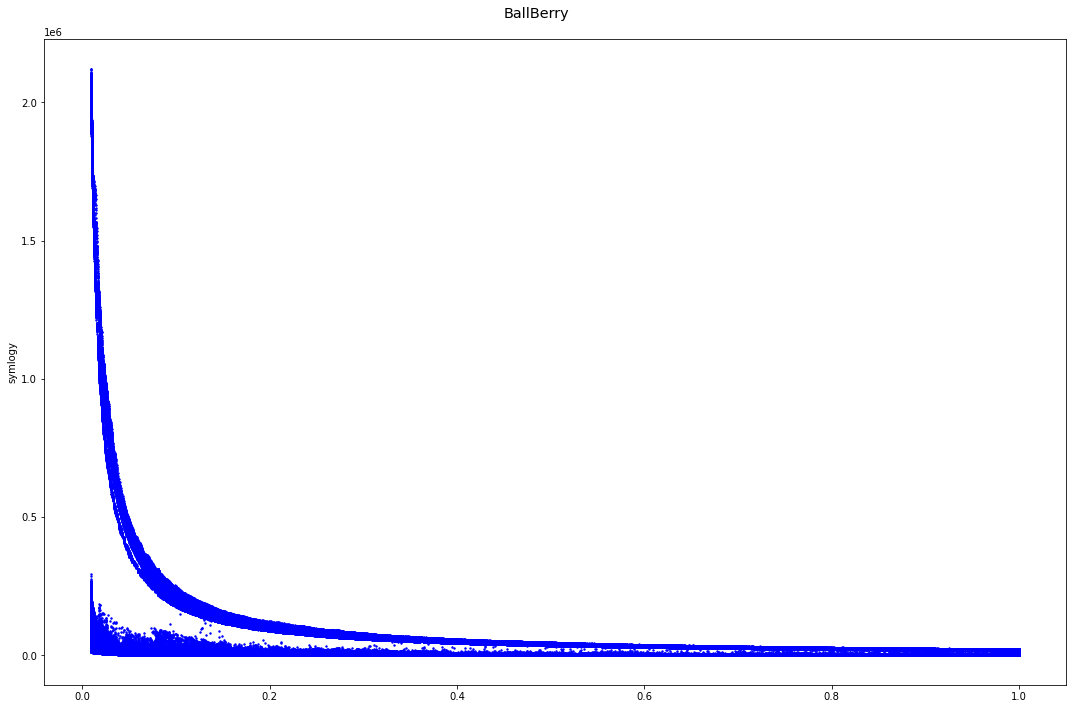

In [33]:

fig, axs = plt.subplots(1, 1, figsize=(15, 10), facecolor='w', edgecolor='k')
stomata = 'BallBerry'
full_title = stomata
fig.suptitle(full_title, fontsize="x-large")
fig.subplots_adjust(hspace=0.7, wspace=0.5)
#axs = axs.ravel()
ldf = []
for i in range(0, 20):
    
    place=places.loc[places.index == i, 'folder'].iloc[0]
    place_plant =places.loc[places.index == i, 'Best'].iloc[0]
    categoria = places.loc[places.index == i, 'IA'].iloc[0]

    summa_vars = ['scalarTranspireLim','scalarStomResistSunlit']
    dataset = get_data(place,stomata,summa_vars)
    df_rel = calculate_some_relations(dataset,summa_vars,stomata + '-'+ place)
    ldf.append(df_rel)
    
    axs.scatter(dataset['scalarTranspireLim'],dataset['scalarStomResistSunlit'],marker = 'o',c='b',s=2)
    #.set_yscale='log'

    #axs[i].set_ylabel('$r_s$ [s $m^{-1}$]')
    #axs[i].set_xlabel('$T_{lim}$')
    #axs[i].set_title(place +'\n' + place_plant)
    #axs[i].grid()
    #axs[i].set_xlim(0,1)
plt.ylabel('symlogy')

fig.tight_layout()    
#plt.savefig(os.path.join(plots,'Trans_lim_BallBerry.png'), dpi=500, bbox_inches='tight')

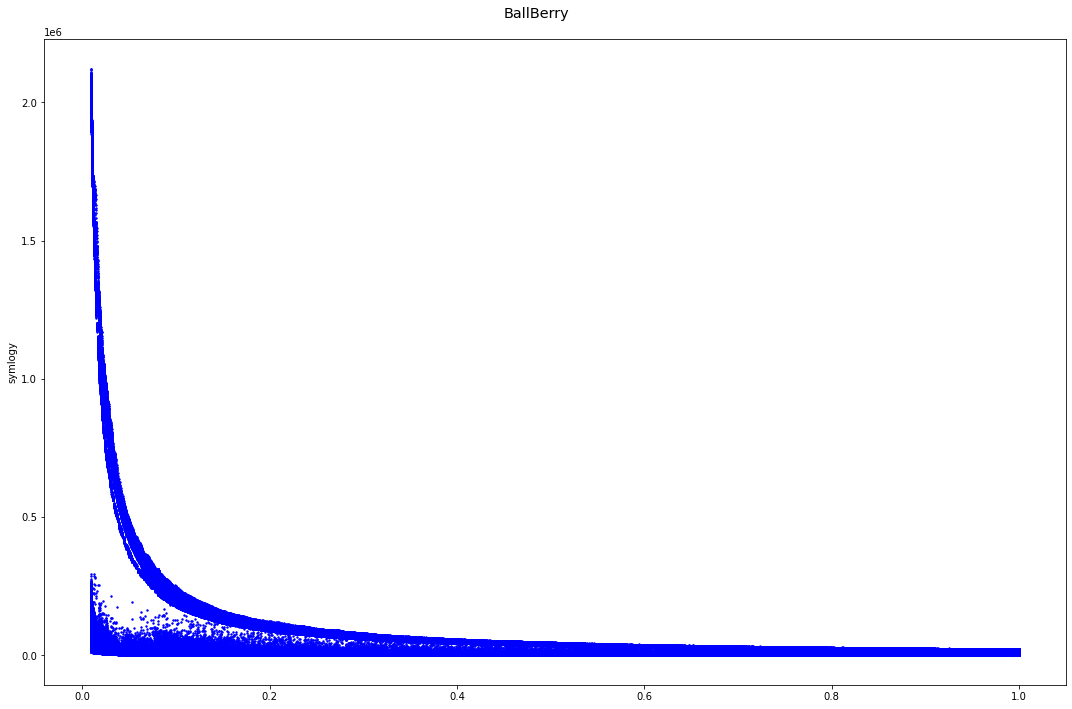

In [66]:
#Exp
fig, axs = plt.subplots(1, 1, figsize=(15, 10), facecolor='w', edgecolor='k')
stomata = 'BallBerry'
full_title = stomata
fig.suptitle(full_title, fontsize="x-large")
fig.subplots_adjust(hspace=0.7, wspace=0.5)
#axs = axs.ravel()
ldf = []
for i in range(0, 20):
    
    place=places.loc[places.index == i, 'folder'].iloc[0]
    place_plant =places.loc[places.index == i, 'Best'].iloc[0]
    categoria = places.loc[places.index == i, 'IA'].iloc[0]

    summa_vars = ['scalarTranspireLim','scalarStomResistShaded']
    dataset = get_data(place,stomata,summa_vars)
    df_rel = calculate_some_relations(dataset,summa_vars,stomata + '-'+ place)
    ldf.append(df_rel)
    
    axs.scatter(dataset['scalarTranspireLim'],dataset['scalarStomResistShaded'],marker = 'o',c='b',s=2)
    #.set_yscale='log'

    #axs[i].set_ylabel('$r_s$ [s $m^{-1}$]')
    #axs[i].set_xlabel('$T_{lim}$')
    #axs[i].set_title(place +'\n' + place_plant)
    #axs[i].grid()
    #axs[i].set_xlim(0,1)
plt.ylabel('symlogy')

fig.tight_layout()    
#plt.savefig(os.path.join(plots,'Trans_lim_BallBerry.png'), dpi=500, bbox_inches='tight')

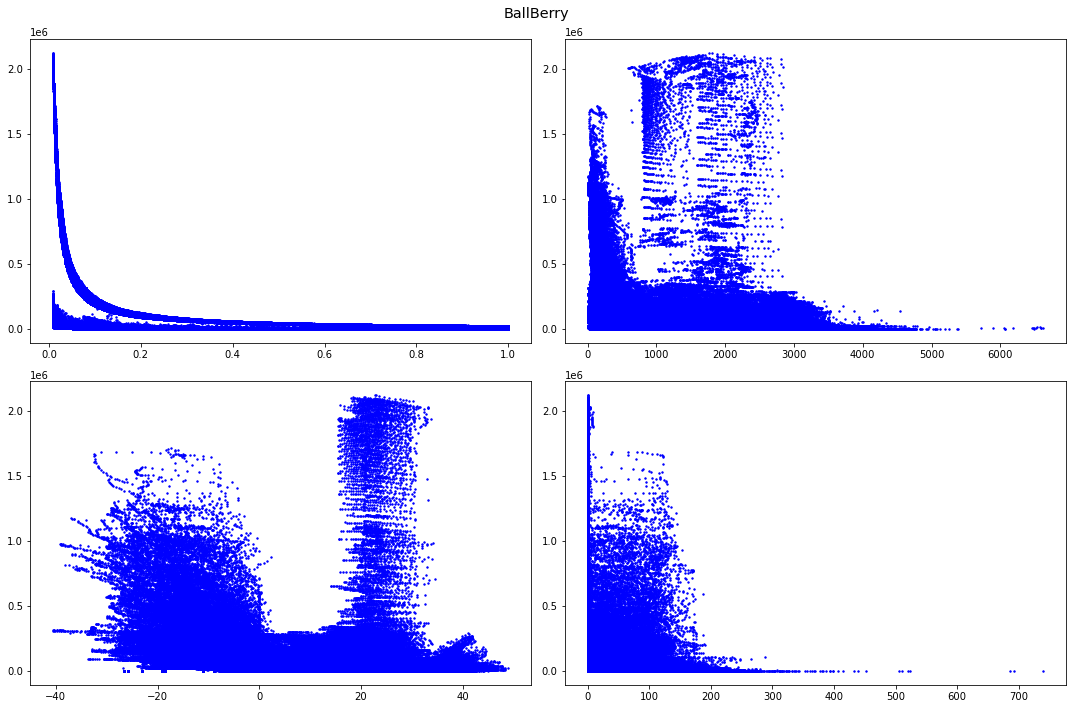

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), facecolor='w', edgecolor='k')
stomata = 'BallBerry'
full_title = stomata
fig.suptitle(full_title, fontsize="x-large")
fig.subplots_adjust(hspace=0.7, wspace=0.5)
axs = axs.ravel()
ldf = []
for i in range(0, 20):
    
    place=places.loc[places.index == i, 'folder'].iloc[0]
    place_plant =places.loc[places.index == i, 'Best'].iloc[0]
    categoria = places.loc[places.index == i, 'IA'].iloc[0]
    
    summa_vars0 = ['scalarTranspireLim','scalarStomResistSunlit']
    dataset0 = get_data(place,stomata,summa_vars0)
    axs[0].scatter(dataset0['scalarTranspireLim'],dataset0['scalarStomResistSunlit'],marker = 'o',c='blue',s=2)
    
    summa_vars1 = ['scalarVP_CanopyAir','scalarStomResistSunlit']
    dataset1 = get_data(place,stomata,summa_vars1)
    axs[1].scatter(dataset1['scalarVP_CanopyAir'],dataset1['scalarStomResistSunlit'],marker = 'o',c='blue',s=2)
    
    summa_vars2 = ['scalarCanopyTemp','scalarStomResistSunlit']
    dataset2 = get_data(place,stomata,summa_vars2)
    dataset2['scalarCanopyTemp'] = dataset2['scalarCanopyTemp']-273.15
    axs[2].scatter(dataset2['scalarCanopyTemp'],dataset2['scalarStomResistSunlit'],marker = 'o',c='blue',s=2)
    
    
    summa_vars3 = ['scalarCanopySunlitPAR','scalarCanopyShadedPAR','scalarStomResistSunlit']
    dataset3 = get_data(place,stomata,summa_vars3)
    dataset3['Light'] = dataset3[['scalarCanopySunlitPAR','scalarCanopyShadedPAR']].mean(axis=1)
    axs[3].scatter(dataset3['Light'],dataset3['scalarStomResistSunlit'],marker = 'o',c='blue',s=2)
    
    #axs[i].set_ylabel('$r_s$ [s $m^{-1}$]')
    #axs[i].set_xlabel('$T_{lim}$')
    #axs[i].set_title(place +'\n' + place_plant)
    #axs[i].grid()
    #axs[i].set_xlim(0,1)
    
    
    
fig.tight_layout()    
#plt.savefig(os.path.join(plots,'Trans_lim_BallBerry.png'), dpi=500, bbox_inches='tight')

In [24]:
for i in range(0, 20):
    
    place=places.loc[places.index == i, 'folder'].iloc[0]
    place_plant =places.loc[places.index == i, 'Best'].iloc[0]
    categoria = places.loc[places.index == i, 'IA'].iloc[0]
    print(place)

Amplero
Bugac
ElSaler
Hesse
UniMich
Tumba
Palang
Blodgett
Hyytiala
Loobos
FortPeck
Harvard
Howlandm
Sylvania
Merbleue
ElSaler2
Kruger
Mopane
Howard
Espirra


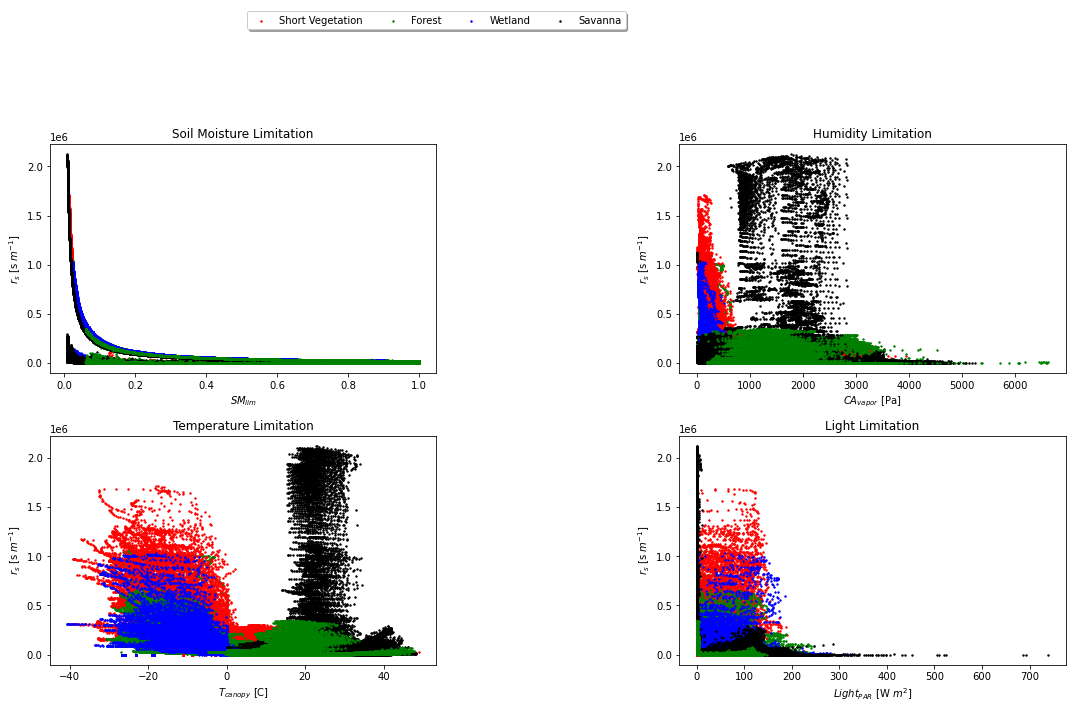

In [ ]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc='upper center', bbox_to_anchor=(1, 1.6),fancybox=True, shadow=True, ncol=4)

fig, axs = plt.subplots(2, 2, figsize=(15, 10), facecolor='w', edgecolor='k')
stomata = 'BallBerry'
full_title = ' '#stomata + ' Parametrization'
fig.suptitle(full_title, fontsize="x-large")
fig.subplots_adjust(hspace=0.7, wspace=0.3)
axs = axs.ravel()
ldf = []
for i in range(0, 20):
    
    place=places.loc[places.index == i, 'folder'].iloc[0]
    place_plant =places.loc[places.index == i, 'Best'].iloc[0]
    categoria = places.loc[places.index == i, 'IA'].iloc[0]
    if categoria == 'Forest':
    
        summa_vars0 = ['scalarTranspireLim','scalarStomResistSunlit']
        dataset0 = get_data(place,stomata,summa_vars0)
        axs[0].scatter(dataset0['scalarTranspireLim'],dataset0['scalarStomResistSunlit'],marker = 'o',c='g',s=2,label='Forest')

        summa_vars1 = ['scalarVP_CanopyAir','scalarStomResistSunlit']
        dataset1 = get_data(place,stomata,summa_vars1)
        axs[1].scatter(dataset1['scalarVP_CanopyAir'],dataset1['scalarStomResistSunlit'],marker = 'o',c='g',s=2)

        summa_vars2 = ['scalarCanopyTemp','scalarStomResistSunlit']
        dataset2 = get_data(place,stomata,summa_vars2)
        dataset2['scalarCanopyTemp'] = dataset2['scalarCanopyTemp']-273.15
        axs[2].scatter(dataset2['scalarCanopyTemp'],dataset2['scalarStomResistSunlit'],marker = 'o',c='g',s=2)


        summa_vars3 = ['scalarCanopySunlitPAR','scalarCanopyShadedPAR','scalarStomResistSunlit']
        dataset3 = get_data(place,stomata,summa_vars3)
        dataset3['Light'] = dataset3[['scalarCanopySunlitPAR','scalarCanopyShadedPAR']].mean(axis=1)
        axs[3].scatter(dataset3['Light'],dataset3['scalarStomResistSunlit'],marker = 'o',c='g',s=2)

    if categoria == 'Short_Vegetation':
    
        summa_vars0 = ['scalarTranspireLim','scalarStomResistSunlit']
        dataset0 = get_data(place,stomata,summa_vars0)
        axs[0].scatter(dataset0['scalarTranspireLim'],dataset0['scalarStomResistSunlit'],marker = 'o',c='r',s=2,label='Short Vegetation')

        summa_vars1 = ['scalarVP_CanopyAir','scalarStomResistSunlit']
        dataset1 = get_data(place,stomata,summa_vars1)
        axs[1].scatter(dataset1['scalarVP_CanopyAir'],dataset1['scalarStomResistSunlit'],marker = 'o',c='r',s=2)

        summa_vars2 = ['scalarCanopyTemp','scalarStomResistSunlit']
        dataset2 = get_data(place,stomata,summa_vars2)
        dataset2['scalarCanopyTemp'] = dataset2['scalarCanopyTemp']-273.15
        axs[2].scatter(dataset2['scalarCanopyTemp'],dataset2['scalarStomResistSunlit'],marker = 'o',c='r',s=2)


        summa_vars3 = ['scalarCanopySunlitPAR','scalarCanopyShadedPAR','scalarStomResistSunlit']
        dataset3 = get_data(place,stomata,summa_vars3)
        dataset3['Light'] = dataset3[['scalarCanopySunlitPAR','scalarCanopyShadedPAR']].mean(axis=1)
        axs[3].scatter(dataset3['Light'],dataset3['scalarStomResistSunlit'],marker = 'o',c='r',s=2)
        
    if categoria == 'Wetland':
    
        summa_vars0 = ['scalarTranspireLim','scalarStomResistSunlit']
        dataset0 = get_data(place,stomata,summa_vars0)
        axs[0].scatter(dataset0['scalarTranspireLim'],dataset0['scalarStomResistSunlit'],marker = 'o',c='b',s=2,label='Wetland')

        summa_vars1 = ['scalarVP_CanopyAir','scalarStomResistSunlit']
        dataset1 = get_data(place,stomata,summa_vars1)
        axs[1].scatter(dataset1['scalarVP_CanopyAir'],dataset1['scalarStomResistSunlit'],marker = 'o',c='b',s=2)

        summa_vars2 = ['scalarCanopyTemp','scalarStomResistSunlit']
        dataset2 = get_data(place,stomata,summa_vars2)
        dataset2['scalarCanopyTemp'] = dataset2['scalarCanopyTemp']-273.15
        axs[2].scatter(dataset2['scalarCanopyTemp'],dataset2['scalarStomResistSunlit'],marker = 'o',c='b',s=2)


        summa_vars3 = ['scalarCanopySunlitPAR','scalarCanopyShadedPAR','scalarStomResistSunlit']
        dataset3 = get_data(place,stomata,summa_vars3)
        dataset3['Light'] = dataset3[['scalarCanopySunlitPAR','scalarCanopyShadedPAR']].mean(axis=1)
        axs[3].scatter(dataset3['Light'],dataset3['scalarStomResistSunlit'],marker = 'o',c='b',s=2)

    
    if categoria == 'Savanna':
    
        summa_vars0 = ['scalarTranspireLim','scalarStomResistSunlit']
        dataset0 = get_data(place,stomata,summa_vars0)
        axs[0].scatter(dataset0['scalarTranspireLim'],dataset0['scalarStomResistSunlit'],marker = 'o',c='k',s=2,label='Savanna')

        summa_vars1 = ['scalarVP_CanopyAir','scalarStomResistSunlit']
        dataset1 = get_data(place,stomata,summa_vars1)
        axs[1].scatter(dataset1['scalarVP_CanopyAir'],dataset1['scalarStomResistSunlit'],marker = 'o',c='k',s=2)

        summa_vars2 = ['scalarCanopyTemp','scalarStomResistSunlit']
        dataset2 = get_data(place,stomata,summa_vars2)
        dataset2['scalarCanopyTemp'] = dataset2['scalarCanopyTemp']-273.15
        axs[2].scatter(dataset2['scalarCanopyTemp'],dataset2['scalarStomResistSunlit'],marker = 'o',c='k',s=2)


        summa_vars3 = ['scalarCanopySunlitPAR','scalarCanopyShadedPAR','scalarStomResistSunlit']
        dataset3 = get_data(place,stomata,summa_vars3)
        dataset3['Light'] = dataset3[['scalarCanopySunlitPAR','scalarCanopyShadedPAR']].mean(axis=1)
        axs[3].scatter(dataset3['Light'],dataset3['scalarStomResistSunlit'],marker = 'o',c='k',s=2)
axs[0].set_ylabel('$r_s$ [s $m^{-1}$]')
axs[1].set_ylabel('$r_s$ [s $m^{-1}$]')
axs[2].set_ylabel('$r_s$ [s $m^{-1}$]')
axs[3].set_ylabel('$r_s$ [s $m^{-1}$]')

axs[0].set_xlabel('$SM_{lim}$') #Soil Moisture
axs[1].set_xlabel('$CA_{vapor}$ [Pa]')
axs[2].set_xlabel('$T_{canopy}$ [C]')
axs[3].set_xlabel('$Light_{PAR}$ [W $m^2$]')

axs[0].set_title('Soil Moisture Limitation')
axs[1].set_title('Humidity Limitation')
axs[2].set_title('Temperature Limitation')
axs[3].set_title('Light Limitation')


legend_without_duplicate_labels(axs[0])

fig.tight_layout()  
#axs[0].legend(loc='lower center', bbox_to_anchor=(-0.5, -0.2),fancybox=True, shadow=True, ncol=4)
plt.savefig(os.path.join(plots,'BallBerry_new35.png'), dpi=500, bbox_inches='tight')

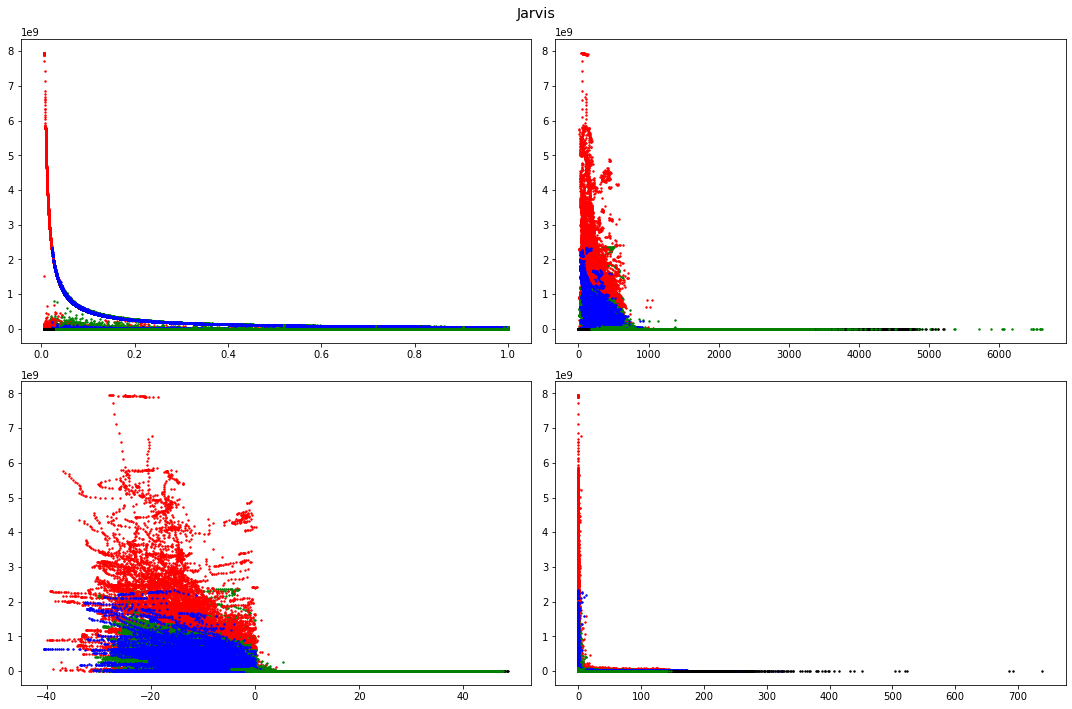

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), facecolor='w', edgecolor='k')
stomata = 'Jarvis'
full_title = stomata
fig.suptitle(full_title, fontsize="x-large")
fig.subplots_adjust(hspace=0.7, wspace=0.5)
axs = axs.ravel()
ldf = []
for i in range(0, 20):
    
    place=places.loc[places.index == i, 'folder'].iloc[0]
    place_plant =places.loc[places.index == i, 'Best'].iloc[0]
    categoria = places.loc[places.index == i, 'IA'].iloc[0]
    if categoria == 'Forest':
    
        summa_vars0 = ['scalarTranspireLim','scalarStomResistSunlit']
        dataset0 = get_data(place,stomata,summa_vars0)
        axs[0].scatter(dataset0['scalarTranspireLim'],dataset0['scalarStomResistSunlit'],marker = 'o',c='g',s=2)

        summa_vars1 = ['scalarVP_CanopyAir','scalarStomResistSunlit']
        dataset1 = get_data(place,stomata,summa_vars1)
        axs[1].scatter(dataset1['scalarVP_CanopyAir'],dataset1['scalarStomResistSunlit'],marker = 'o',c='g',s=2)

        summa_vars2 = ['scalarCanopyTemp','scalarStomResistSunlit']
        dataset2 = get_data(place,stomata,summa_vars2)
        dataset2['scalarCanopyTemp'] = dataset2['scalarCanopyTemp']-273.15
        axs[2].scatter(dataset2['scalarCanopyTemp'],dataset2['scalarStomResistSunlit'],marker = 'o',c='g',s=2)


        summa_vars3 = ['scalarCanopySunlitPAR','scalarCanopyShadedPAR','scalarStomResistSunlit']
        dataset3 = get_data(place,stomata,summa_vars3)
        dataset3['Light'] = dataset3[['scalarCanopySunlitPAR','scalarCanopyShadedPAR']].mean(axis=1)
        axs[3].scatter(dataset3['Light'],dataset3['scalarStomResistSunlit'],marker = 'o',c='g',s=2)
    
    if categoria == 'Short_Vegetation':
    
        summa_vars0 = ['scalarTranspireLim','scalarStomResistSunlit']
        dataset0 = get_data(place,stomata,summa_vars0)
        axs[0].scatter(dataset0['scalarTranspireLim'],dataset0['scalarStomResistSunlit'],marker = 'o',c='r',s=2)

        summa_vars1 = ['scalarVP_CanopyAir','scalarStomResistSunlit']
        dataset1 = get_data(place,stomata,summa_vars1)
        axs[1].scatter(dataset1['scalarVP_CanopyAir'],dataset1['scalarStomResistSunlit'],marker = 'o',c='r',s=2)

        summa_vars2 = ['scalarCanopyTemp','scalarStomResistSunlit']
        dataset2 = get_data(place,stomata,summa_vars2)
        dataset2['scalarCanopyTemp'] = dataset2['scalarCanopyTemp']-273.15
        axs[2].scatter(dataset2['scalarCanopyTemp'],dataset2['scalarStomResistSunlit'],marker = 'o',c='r',s=2)


        summa_vars3 = ['scalarCanopySunlitPAR','scalarCanopyShadedPAR','scalarStomResistSunlit']
        dataset3 = get_data(place,stomata,summa_vars3)
        dataset3['Light'] = dataset3[['scalarCanopySunlitPAR','scalarCanopyShadedPAR']].mean(axis=1)
        axs[3].scatter(dataset3['Light'],dataset3['scalarStomResistSunlit'],marker = 'o',c='r',s=2)
        
    if categoria == 'Wetland':
    
        summa_vars0 = ['scalarTranspireLim','scalarStomResistSunlit']
        dataset0 = get_data(place,stomata,summa_vars0)
        axs[0].scatter(dataset0['scalarTranspireLim'],dataset0['scalarStomResistSunlit'],marker = 'o',c='b',s=2)

        summa_vars1 = ['scalarVP_CanopyAir','scalarStomResistSunlit']
        dataset1 = get_data(place,stomata,summa_vars1)
        axs[1].scatter(dataset1['scalarVP_CanopyAir'],dataset1['scalarStomResistSunlit'],marker = 'o',c='b',s=2)

        summa_vars2 = ['scalarCanopyTemp','scalarStomResistSunlit']
        dataset2 = get_data(place,stomata,summa_vars2)
        dataset2['scalarCanopyTemp'] = dataset2['scalarCanopyTemp']-273.15
        axs[2].scatter(dataset2['scalarCanopyTemp'],dataset2['scalarStomResistSunlit'],marker = 'o',c='b',s=2)


        summa_vars3 = ['scalarCanopySunlitPAR','scalarCanopyShadedPAR','scalarStomResistSunlit']
        dataset3 = get_data(place,stomata,summa_vars3)
        dataset3['Light'] = dataset3[['scalarCanopySunlitPAR','scalarCanopyShadedPAR']].mean(axis=1)
        axs[3].scatter(dataset3['Light'],dataset3['scalarStomResistSunlit'],marker = 'o',c='b',s=2)

    
    if categoria == 'Savanna':
    
        summa_vars0 = ['scalarTranspireLim','scalarStomResistSunlit']
        dataset0 = get_data(place,stomata,summa_vars0)
        axs[0].scatter(dataset0['scalarTranspireLim'],dataset0['scalarStomResistSunlit'],marker = 'o',c='k',s=2)

        summa_vars1 = ['scalarVP_CanopyAir','scalarStomResistSunlit']
        dataset1 = get_data(place,stomata,summa_vars1)
        axs[1].scatter(dataset1['scalarVP_CanopyAir'],dataset1['scalarStomResistSunlit'],marker = 'o',c='k',s=2)

        summa_vars2 = ['scalarCanopyTemp','scalarStomResistSunlit']
        dataset2 = get_data(place,stomata,summa_vars2)
        dataset2['scalarCanopyTemp'] = dataset2['scalarCanopyTemp']-273.15
        axs[2].scatter(dataset2['scalarCanopyTemp'],dataset2['scalarStomResistSunlit'],marker = 'o',c='k',s=2)


        summa_vars3 = ['scalarCanopySunlitPAR','scalarCanopyShadedPAR','scalarStomResistSunlit']
        dataset3 = get_data(place,stomata,summa_vars3)
        dataset3['Light'] = dataset3[['scalarCanopySunlitPAR','scalarCanopyShadedPAR']].mean(axis=1)
        axs[3].scatter(dataset3['Light'],dataset3['scalarStomResistSunlit'],marker = 'o',c='k',s=2)
    
    
fig.tight_layout()    
#plt.savefig(os.path.join(plots,'Trans_lim_BallBerry.png'), dpi=500, bbox_inches='tight')